In [1]:
import numpy as np
import scipy as sp
from scipy import integrate
import matplotlib.pyplot as plt
import sys
#sys.path.append("/Users/tcasey/.pyenv/versions/3.10.4/lib/python3.10/site-packages")
import h5py

import os

import pandas as pd

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')

Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


In [2]:
OutputDir   = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/PDFEvolve_10Cases/')


#define domain
Npts=50
x = np.linspace(-2.,2.,Npts)

#generate data
sig1=0.5
mu1=0.0
sig2=0.1
mu2=-1.75 #use this as parametet to vary initial conditions
nSamps=10
mu2_samps = np.random.uniform(-1.75, -1.25, nSamps) #uniform random samples


try:
    os.makedirs(OutputDir)
except OSError as e:
    pass

h        = x[1] - x[0]

In [3]:
x_names  = ['x_'+str(i+1) for i in range(Npts)]
x0_names = ['x0_'+str(i+1) for i in range(Npts)]

In [4]:
#background density
f1     = 1./(sig1*np.sqrt(2.*np.pi)) * np.exp( -(x-mu1)**2. /(2.*sig1**2.))
#cdf
f1_int =  integrate.cumtrapz(f1, x=x, axis=-1, initial=None)


pdf_all  = []
cdf_all  = []
pdf_all_ = []
for i in range(0,mu2_samps.shape[0]) :
    mu2=mu2_samps[i]
    #do all the data generation and write output hdf5 files
    #pass
    T=1.
    dt=0.01
    vt=3.
    nt = int(T/dt)
    #print('nt=',nt)
    t=np.linspace(0,T,nt)

    #container for output
    pdf_t = np.zeros((Npts,nt))
    cdf_t = np.zeros((Npts,nt))

    #initial condition
    f2     = 1./(sig2*np.sqrt(2.*np.pi)) * np.exp( -(x-mu2)**2. /(2.*sig2**2.))
    f      = (f1+0.2*f2)
    pdf_t0 = f/np.trapz(f,x)
    cdf_t0 = np.append([1.e-14], integrate.cumtrapz(pdf_t0, x=x, axis=-1, initial=None))
    
    #time evolution
    for it, t_ in enumerate(range(0,nt)):
        mu2=mu2 + vt*dt
        #print(mu2)
        f2 = 1./(sig2*np.sqrt(2.*np.pi)) * np.exp( -(x-mu2)**2. /(2.*sig2**2.))
        f=(f1+0.2*f2)
        #normalize
        f=f/np.trapz(f,x)
        #store
        pdf_t[:,t_]=f #pdf
        cdf_t[:,t_]=np.append([1.e-14], integrate.cumtrapz(pdf_t[:,t_], x=x, axis=-1, initial=None)) #cdf
        
    pdf_df           = pd.DataFrame(pdf_t.T, columns=x_names)  
    pdf_df[x0_names] = np.tile(pdf_t0[np.newaxis,...], (nt,1)) 
    pdf_df['t']      = t
    pdf_all.append(pdf_df)
    
    cdf_df           = pd.DataFrame(np.log10(cdf_t.T), columns=x_names)
    cdf_df[x0_names] = np.tile(np.log10(cdf_t0)[np.newaxis,...], (nt,1))
    cdf_df['t']      = t
    cdf_all.append(cdf_df)

    pdf_df_           = pd.DataFrame(pdf_t.T, columns=x_names)  * h
    pdf_df_[x0_names] = np.tile(pdf_t0[np.newaxis,...], (nt,1)) * h
    pdf_df_['t']      = t
    pdf_all_.append(pdf_df_)
    
    
    #normalization check
    #print(np.trapz(f,x))

    #write data sets to file
    #probably want to pack all the data fields into a single hdf5 file within the 'i' loop
#     f1_ = h5py.File(OutputDir+'/pdf_t_'+str(i)+'.hdf5', 'w')
#     tmp_ = f1_.create_dataset("p_xt", data=pdf_t, dtype='f')
#     tmp_ = f1_.create_dataset("x", data=x, dtype='f')
#     tmp_ = f1_.create_dataset("t", data=t, dtype='f')
#     f1_.close()

#     c1_ = h5py.File(OutputDir+'/cdf_t_'+str(i)+'.hdf5', 'w')
#     tmp_ = c1_.create_dataset("c_xt", data=cdf_t, dtype='f')
#     tmp_ = c1_.create_dataset("x", data=x, dtype='f')
#     tmp_ = c1_.create_dataset("t", data=t, dtype='f')
#     c1_.close()
    
pdf_all  = pd.concat(pdf_all, axis=0)
cdf_all  = pd.concat(cdf_all, axis=0)
pdf_all_ = pd.concat(pdf_all_, axis=0)

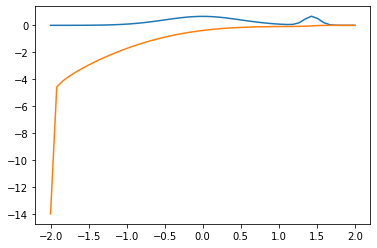

In [5]:
iloc = 90

plt.plot(x, pdf_all[x_names].iloc[iloc])
plt.plot(x, cdf_all[x_names].iloc[iloc])

In [6]:
cdf_all

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x0_42,x0_43,x0_44,x0_45,x0_46,x0_47,x0_48,x0_49,x0_50,t
0,-14.0,-4.578944,-4.122061,-3.782990,-3.482688,-3.131801,-2.572161,-1.923142,-1.400860,-1.054766,...,-0.001291,-0.000778,-0.000455,-0.000258,-0.00014,-0.000072,-0.000033,-0.000011,0.0,0.000000
1,-14.0,-4.578944,-4.122072,-3.783345,-3.489309,-3.190929,-2.752804,-2.135171,-1.564465,-1.157424,...,-0.001291,-0.000778,-0.000455,-0.000258,-0.00014,-0.000072,-0.000033,-0.000011,0.0,0.010101
2,-14.0,-4.578944,-4.122073,-3.783425,-3.491227,-3.214836,-2.872923,-2.338336,-1.745373,-1.280406,...,-0.001291,-0.000778,-0.000455,-0.000258,-0.00014,-0.000072,-0.000033,-0.000011,0.0,0.020202
3,-14.0,-4.578944,-4.122074,-3.783441,-3.491731,-3.223161,-2.936693,-2.508970,-1.935476,-1.422967,...,-0.001291,-0.000778,-0.000455,-0.000258,-0.00014,-0.000072,-0.000033,-0.000011,0.0,0.030303
4,-14.0,-4.578944,-4.122074,-3.783444,-3.491852,-3.225744,-2.964482,-2.628297,-2.120274,-1.582049,...,-0.001291,-0.000778,-0.000455,-0.000258,-0.00014,-0.000072,-0.000033,-0.000011,0.0,0.040404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-14.0,-4.578944,-4.122074,-3.783445,-3.491885,-3.226710,-2.979752,-2.747294,-2.527497,-2.319382,...,-0.001291,-0.000778,-0.000455,-0.000258,-0.00014,-0.000072,-0.000033,-0.000011,0.0,0.959596
96,-14.0,-4.578944,-4.122074,-3.783445,-3.491885,-3.226710,-2.979751,-2.747294,-2.527497,-2.319382,...,-0.001291,-0.000778,-0.000455,-0.000258,-0.00014,-0.000072,-0.000033,-0.000011,0.0,0.969697
97,-14.0,-4.578944,-4.122073,-3.783444,-3.491884,-3.226709,-2.979751,-2.747293,-2.527496,-2.319382,...,-0.001291,-0.000778,-0.000455,-0.000258,-0.00014,-0.000072,-0.000033,-0.000011,0.0,0.979798
98,-14.0,-4.578941,-4.122071,-3.783442,-3.491882,-3.226707,-2.979749,-2.747291,-2.527494,-2.319379,...,-0.001291,-0.000778,-0.000455,-0.000258,-0.00014,-0.000072,-0.000033,-0.000011,0.0,0.989899


In [7]:
from sklearn.model_selection import train_test_split

try:
    os.makedirs(OutputDir+'/PDF/')
except:
    pass
try:
    os.makedirs(OutputDir+'/PDF/train/')
except:
    pass
try:
    os.makedirs(OutputDir+'/PDF/valid/')
except:
    pass

In [8]:
data_id    = 'pts'

DataInput  = pd.DataFrame(pdf_all[['t']+x0_names])
DataOutput = pd.DataFrame(pdf_all[['t']+x_names])
                          
n_points   = len(DataInput)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=0.2, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/PDF/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/PDF/valid/'+data_id+'/')
except:
    pass
DataInput.iloc[train_idx].to_csv(OutputDir+'/PDF/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/PDF/valid/'+data_id+'/Input.csv', index=False)

DataOutput.iloc[train_idx].to_csv(OutputDir+'/PDF/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/PDF/valid/'+data_id+'/Output.csv', index=False)

In [9]:
data_id    = 'pts'

DataInput  = pd.DataFrame(cdf_all[['t']+x0_names])
DataOutput = pd.DataFrame(cdf_all[['t']+x_names])
                          
n_points   = len(DataInput)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=0.2, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/CDF/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/CDF/valid/'+data_id+'/')
except:
    pass
DataInput.iloc[train_idx].to_csv(OutputDir+'/CDF/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/CDF/valid/'+data_id+'/Input.csv', index=False)

DataOutput.iloc[train_idx].to_csv(OutputDir+'/CDF/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/CDF/valid/'+data_id+'/Output.csv', index=False)

In [10]:
data_id    = 'pts'

DataInput  = pd.DataFrame(pdf_all_[['t']+x0_names])
DataOutput = pd.DataFrame(pdf_all_[['t']+x_names])
                          
n_points   = len(DataInput)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=0.2, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/PDFNorm/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/PDFNorm/valid/'+data_id+'/')
except:
    pass
DataInput.iloc[train_idx].to_csv(OutputDir+'/PDFNorm/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/PDFNorm/valid/'+data_id+'/Input.csv', index=False)

DataOutput.iloc[train_idx].to_csv(OutputDir+'/PDFNorm/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/PDFNorm/valid/'+data_id+'/Output.csv', index=False)

In [11]:
try:
    os.makedirs(OutputDir+'/PDF/test/ext/')
except:
    pass

try:
    os.makedirs(OutputDir+'/CDF/test/ext/')
except:
    pass

try:
    os.makedirs(OutputDir+'/PDFNorm/test/ext/')
except:
    pass

In [12]:
#background density
f1 = 1./(sig1*np.sqrt(2.*np.pi)) * np.exp( -(x-mu1)**2. /(2.*sig1**2.))
#cdf
f1_int =  integrate.cumtrapz(f1, x=x, axis=-1, initial=None)


pdf_all  = []
cdf_all  = []
pdf_all_ = []
for i in range(0,mu2_samps.shape[0]) :
    mu2=mu2_samps[i]
    #do all the data generation and write output hdf5 files
    #pass
    T=1.
    dt=0.01
    vt=3.
    nt = int(T/dt)
    #print('nt=',nt)
    t=np.linspace(0,T,nt)

    #container for output
    pdf_t = np.zeros((Npts,nt))
    cdf_t = np.zeros((Npts,nt))

    #initial condition
    f2 = 1./(sig2*np.sqrt(2.*np.pi)) * np.exp( -(x-mu2)**2. /(2.*sig2**2.))
    f=(f1+0.2*f2)
    pdf_t0=f/np.trapz(f,x)
    cdf_t0 = np.append([1.e-14], integrate.cumtrapz(pdf_t0, x=x, axis=-1, initial=None))

    #time evolution
    for it, t_ in enumerate(range(0,nt)):
        mu2=mu2 + vt*dt
        #print(mu2)
        f2 = 1./(sig2*np.sqrt(2.*np.pi)) * np.exp( -(x-mu2)**2. /(2.*sig2**2.))
        f=(f1+0.2*f2)
        #normalize
        f=f/np.trapz(f,x)
        #store
        pdf_t[:,t_]=f #pdf
        cdf_t[:,t_]=np.append([1.e-14], integrate.cumtrapz(pdf_t[:,t_], x=x, axis=-1, initial=None)) #cdf
        
    pdf_df           = pd.DataFrame(pdf_t.T, columns=x_names)
    pdf_df[x0_names] = np.tile(pdf_t0[np.newaxis,...], (nt,1))
    pdf_df['t']      = t
    pdf_all.append(pdf_df)
    pdf_df.to_csv(OutputDir+'/PDF/test/ext/y.csv.'+str(i+1), index=False)

    cdf_df           = pd.DataFrame(np.log10(cdf_t.T), columns=x_names)
    cdf_df[x0_names] = np.tile(np.log10(cdf_t0)[np.newaxis,...], (nt,1))
    cdf_df['t']      = t    
    cdf_all.append(cdf_df)
    cdf_df.to_csv(OutputDir+'/CDF/test/ext/y.csv.'+str(i+1), index=False)
    
    pdf_df_           = pd.DataFrame(pdf_t.T, columns=x_names)  * h 
    pdf_df_[x0_names] = np.tile(pdf_t0[np.newaxis,...], (nt,1)) * h 
    pdf_df_['t']      = t
    pdf_all_.append(pdf_df_)
    pdf_df_.to_csv(OutputDir+'/PDFNorm/test/ext/y.csv.'+str(i+1), index=False)
    
    
    #normalization check
    #print(np.trapz(f,x))

    #write data sets to file
    #probably want to pack all the data fields into a single hdf5 file within the 'i' loop
#     f1_ = h5py.File(OutputDir+'/pdf_t_'+str(i)+'.hdf5', 'w')
#     tmp_ = f1_.create_dataset("p_xt", data=pdf_t, dtype='f')
#     tmp_ = f1_.create_dataset("x", data=x, dtype='f')
#     tmp_ = f1_.create_dataset("t", data=t, dtype='f')
#     f1_.close()

#     c1_ = h5py.File(OutputDir+'/cdf_t_'+str(i)+'.hdf5', 'w')
#     tmp_ = c1_.create_dataset("c_xt", data=cdf_t, dtype='f')
#     tmp_ = c1_.create_dataset("x", data=x, dtype='f')
#     tmp_ = c1_.create_dataset("t", data=t, dtype='f')
#     c1_.close()
    
pdf_all  = pd.concat(pdf_all,  axis=0)
cdf_all  = pd.concat(cdf_all,  axis=0)
pdf_all_ = pd.concat(pdf_all_, axis=0)

In [15]:
pdf_all

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x0_42,x0_43,x0_44,x0_45,x0_46,x0_47,x0_48,x0_49,x0_50,t
0,0.000223,0.000423,0.000781,0.001408,0.002617,0.007407,0.040121,0.186695,0.494307,0.691990,...,0.017658,0.011224,0.006947,0.004186,0.002456,0.001403,0.000781,0.000423,0.000223,0.000000
1,0.000223,0.000423,0.000781,0.001404,0.002502,0.005343,0.022160,0.114023,0.374390,0.662796,...,0.017658,0.011224,0.006947,0.004186,0.002456,0.001403,0.000781,0.000423,0.000223,0.010101
2,0.000223,0.000423,0.000781,0.001404,0.002468,0.004566,0.013323,0.066265,0.261663,0.582568,...,0.017658,0.011224,0.006947,0.004186,0.002456,0.001403,0.000781,0.000423,0.000223,0.020202
3,0.000223,0.000423,0.000781,0.001403,0.002459,0.004300,0.009389,0.038158,0.170193,0.470685,...,0.017658,0.011224,0.006947,0.004186,0.002456,0.001403,0.000781,0.000423,0.000223,0.030303
4,0.000223,0.000423,0.000781,0.001403,0.002457,0.004217,0.007802,0.023270,0.104805,0.350843,...,0.017658,0.011224,0.006947,0.004186,0.002456,0.001403,0.000781,0.000423,0.000223,0.040404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000223,0.000423,0.000781,0.001403,0.002456,0.004186,0.006947,0.011224,0.017658,0.027050,...,0.017658,0.011224,0.006947,0.004186,0.002456,0.001403,0.000781,0.000423,0.000223,0.959596
96,0.000223,0.000423,0.000781,0.001403,0.002456,0.004186,0.006947,0.011224,0.017658,0.027050,...,0.017658,0.011224,0.006947,0.004186,0.002456,0.001403,0.000781,0.000423,0.000223,0.969697
97,0.000223,0.000423,0.000781,0.001403,0.002456,0.004186,0.006947,0.011224,0.017658,0.027050,...,0.017658,0.011224,0.006947,0.004186,0.002456,0.001403,0.000781,0.000423,0.000223,0.979798
98,0.000223,0.000423,0.000781,0.001403,0.002456,0.004186,0.006947,0.011224,0.017658,0.027050,...,0.017658,0.011224,0.006947,0.004186,0.002456,0.001403,0.000781,0.000423,0.000223,0.989899


In [16]:
pdf_all_

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x0_42,x0_43,x0_44,x0_45,x0_46,x0_47,x0_48,x0_49,x0_50,t
0,0.000018,0.000035,0.000064,0.000115,0.000214,0.000605,0.003275,0.015240,0.040352,0.056489,...,0.001441,0.000916,0.000567,0.000342,0.000201,0.000115,0.000064,0.000035,0.000018,0.000000
1,0.000018,0.000035,0.000064,0.000115,0.000204,0.000436,0.001809,0.009308,0.030562,0.054106,...,0.001441,0.000916,0.000567,0.000342,0.000201,0.000115,0.000064,0.000035,0.000018,0.010101
2,0.000018,0.000035,0.000064,0.000115,0.000201,0.000373,0.001088,0.005409,0.021360,0.047557,...,0.001441,0.000916,0.000567,0.000342,0.000201,0.000115,0.000064,0.000035,0.000018,0.020202
3,0.000018,0.000035,0.000064,0.000115,0.000201,0.000351,0.000766,0.003115,0.013893,0.038423,...,0.001441,0.000916,0.000567,0.000342,0.000201,0.000115,0.000064,0.000035,0.000018,0.030303
4,0.000018,0.000035,0.000064,0.000115,0.000201,0.000344,0.000637,0.001900,0.008556,0.028640,...,0.001441,0.000916,0.000567,0.000342,0.000201,0.000115,0.000064,0.000035,0.000018,0.040404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000018,0.000035,0.000064,0.000115,0.000201,0.000342,0.000567,0.000916,0.001441,0.002208,...,0.001441,0.000916,0.000567,0.000342,0.000201,0.000115,0.000064,0.000035,0.000018,0.959596
96,0.000018,0.000035,0.000064,0.000115,0.000201,0.000342,0.000567,0.000916,0.001441,0.002208,...,0.001441,0.000916,0.000567,0.000342,0.000201,0.000115,0.000064,0.000035,0.000018,0.969697
97,0.000018,0.000035,0.000064,0.000115,0.000201,0.000342,0.000567,0.000916,0.001442,0.002208,...,0.001441,0.000916,0.000567,0.000342,0.000201,0.000115,0.000064,0.000035,0.000018,0.979798
98,0.000018,0.000035,0.000064,0.000115,0.000201,0.000342,0.000567,0.000916,0.001442,0.002208,...,0.001441,0.000916,0.000567,0.000342,0.000201,0.000115,0.000064,0.000035,0.000018,0.989899


In [14]:
#load hdf5

f2_=h5py.File(OutputDir+'/pdf_t_0.hdf5', 'r')
list(f2_.keys())
pdf_t = f2_['p_xt'][:]
x= f2_['x'][:]
t= f2_['t'][:]
f2_.close()

c2_=h5py.File(OutputDir+'/cdf_t_0.hdf5', 'r')
list(c2_.keys())
cdf_t = c2_['c_xt'][:]
#x= c2_['x']
#t= c2_['t']
c2_.close()

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/Users/sventur/WORKSPACE/ROMNet/romnet/scripts/generating_data/PDFEvolve/../../../../../ROMNet/Data/PDFEvolve_10Cases//pdf_t_0.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# ====== line plot =============
plt.plot(x,f,'bo')
plt.xlabel('x',fontsize=14)
plt.ylabel('f(x)',fontsize=14)
plt.grid()
plt.title('pdf',fontsize=14)
plt.show()
# ============================


#cdf
f_int =  integrate.cumtrapz(f, x=x, axis=-1, initial=None)
# ====== line plot =============
plt.plot(x[0:-1],f_int,'bo')
plt.xlabel('x',fontsize=14)
plt.ylabel('c(x)',fontsize=14)
plt.grid()
plt.title('cdf',fontsize=14)
plt.show()
# ============================

In [ ]:
#plot saved data (hdf5)

# ====== line plot =============
n=25
plt.plot(t,cdf_t[n,:],'bo')
plt.xlabel('t',fontsize=14)
s = '{0:.3g}'.format(x[n])
plt.ylabel('p(x='+s+')',fontsize=14)
plt.grid()
plt.title('p(x,t)',fontsize=14)
plt.show()
# ============================


# ====== line plot =============
Npts=pdf_t.shape[0]
for n in range(0,Npts):
    plt.plot(t,pdf_t[n,:],'-')
plt.xlabel('t',fontsize=14)
plt.ylabel('p(t)',fontsize=14)
plt.grid()
plt.title('PDF, p(x,t)',fontsize=14)
plt.show()
# ============================

# ====== line plot =============
for n in range(0,Npts-1):
    plt.plot(t,cdf_t[n,:],'-')
plt.xlabel('t',fontsize=14)
plt.ylabel('p(t)',fontsize=14)
plt.grid()
plt.title('CDF, p(x,t)',fontsize=14)
plt.show()
# ============================